## Training and Evaluation of CRNet model on Hubble Space Telescope (HST) Cosmic-Ray (CR) Dataset

### CRNet is trained using Unet (2-32) Model.

#### Step 0: Reproducible Training Environment and Deterministic Data Pipeline Setup

In [1]:
# --- Determinism / Reproducibility (env-level) ---
import os
SEED = 1

# Deterministic hashing (dict/set ordering)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Deterministic cuBLAS GEMM behavior (CUDA >= 10.2)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Optional (slower but steadier CPU behavior)
# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"

print("Seed (env) =", SEED)
print("CUBLAS_WORKSPACE_CONFIG =", os.environ.get("CUBLAS_WORKSPACE_CONFIG"))



Seed (env) = 1
CUBLAS_WORKSPACE_CONFIG = :4096:8


#### Standard Imports (After Environment Is Fixed)

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import gc
import random
import matplotlib.pyplot as plt
import sys
import shutil
import tarfile
import urllib
import seaborn as sns   
import torch
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsinhStretch
from torch.utils.data import DataLoader

from CRNet import CRNet
from CRNet.evaluate import roc, roc_lacosmic
from CRNet import train
from CRNet.util import plotCRDetection, plotFirstConvFilters


#### Global Seeding for Python, NumPy, and PyTorch

In [3]:
def seed_everything(seed: int = 1, deterministic: bool = True) -> None:
    # Python / NumPy
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        # cuDNN behavior
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

        # Disable TF32 (Ampere+ GPUs)
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False

        # Enforce deterministic algorithms
        torch.use_deterministic_algorithms(True)

seed_everything(SEED, deterministic=True)

print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("cuda device:", torch.cuda.get_device_name(0))
        

torch version: 2.0.0+cu117
cuda available: True
cuda device: NVIDIA A100-PCIE-40GB


#### Deterministic DataLoader Worker Seeding and Create Deterministic Train / Validation DataLoaders

In [4]:
def seed_worker(worker_id: int) -> None:
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def make_deterministic_loaders(trainer, seed: int = 1, num_workers: int = 8):
    g = torch.Generator()
    g.manual_seed(seed)

    train_ds = trainer.TrainLoader.dataset
    val_ds   = trainer.ValLoader.dataset
    bs       = trainer.TrainLoader.batch_size

    common = dict(
        batch_size=bs,
        num_workers=num_workers,
        pin_memory=trainer.is_cuda,
        worker_init_fn=seed_worker,
        generator=g,
        persistent_workers=(trainer.is_cuda and num_workers > 0),
    )

    trainer.TrainLoader = DataLoader(train_ds, shuffle=True,  **common)
    trainer.ValLoader   = DataLoader(val_ds,   shuffle=False, **common)
    

#### Define Paths and Training Configuration

In [5]:
BASE_DIR = "/scratch/srinadb/CRNet/CRNet/deepCR.ACS-WFC"

MODEL_NAME   = "ACS-WFC-AttGN-16"
OUT_DIR      = MODEL_NAME + os.sep
MODEL_KWARGS = {"hidden": 32, "act_norm": "group", "att": True}
AUG_SKY      = (-0.9, 3)

os.makedirs(OUT_DIR, exist_ok=True)

print("base_dir:", BASE_DIR)
print("out_dir :", OUT_DIR)


base_dir: /scratch/srinadb/CRNet/CRNet/deepCR.ACS-WFC
out_dir : ACS-WFC-AttGN-16/


#### Step 1: CRNet (UNet (2-32) Training Wrapper

In [6]:
def model_train(epoch: int = 50, epoch_phase0=50, num_workers: int = 8):
    train_dirs = np.load(
        os.path.join(BASE_DIR, "train_dirs.npy"),
        allow_pickle=True
    )

    print("-" * 60)
    print("Training segmentation model (UNet2)")
    print("-" * 60)

    trainer = train(
        train_dirs,
        aug_sky=AUG_SKY,
        model_kwargs=MODEL_KWARGS,
        name=MODEL_NAME,
        epoch=epoch,
        epoch_phase0=epoch_phase0,
        batch_size=16,
        directory=OUT_DIR,
    )

    # Enforce deterministic DataLoaders
    make_deterministic_loaders(trainer, seed=SEED, num_workers=num_workers)
    print("trainer.directory =", repr(trainer.directory))

    try:
        trainer.train()
        trainer.plot_loss()

        np.save(
            os.path.join(OUT_DIR, "val_loss.npy"),
            np.asarray(trainer.validation_loss, dtype=np.float32),
        )

        return trainer.save()

    finally:
        del trainer
        gc.collect()

        

In [7]:
mdl = model_train(epoch=50, num_workers=8)
print("Saved model id:", mdl)


------------------------------------------------------------
Training segmentation model (UNet2)
------------------------------------------------------------
trainer.directory = 'ACS-WFC-AttGN-16/'
Begin first 50 epochs of training
Use batch statistics for batch normalization; keep running statistics to be used in phase1

----------- epoch = 1 -----------
[val_loss=0.010062, TPR=0.851, FPR=0.002] @threshold = 0.5
Saved to ACS-WFC-AttGN-16.pth

----------- epoch = 2 -----------
[val_loss=0.007235, TPR=0.857, FPR=0.001] @threshold = 0.5
Saved to ACS-WFC-AttGN-16.pth

----------- epoch = 3 -----------
[val_loss=0.007318, TPR=0.871, FPR=0.001] @threshold = 0.5

----------- epoch = 4 -----------
[val_loss=0.006778, TPR=0.906, FPR=0.002] @threshold = 0.5
Saved to ACS-WFC-AttGN-16.pth

----------- epoch = 5 -----------
[val_loss=0.005734, TPR=0.882, FPR=0.001] @threshold = 0.5
Saved to ACS-WFC-AttGN-16.pth

----------- epoch = 6 -----------
[val_loss=0.005722, TPR=0.892, FPR=0.001] @threshold

#### Step 2: Call the final best model
#### Python API 

In [8]:
mask_path = os.path.join(OUT_DIR, f"{MODEL_NAME}.pth")

crnet = CRNet(
    mask=mask_path,
    device="GPU",          # or "CPU"
    model_kwargs=MODEL_KWARGS,
    scale=1.0,
    norm=True,
)


In [9]:
npy_path = os.path.join(BASE_DIR, 'data', 'npy_test', 'f435w', '9694', '6', '1_210.npy')
data = np.load(npy_path)

# the model outputs a CR probability map in np.float32
pdt_mask, clean = crnet.clean(data[0], threshold=0.5, inpaint=True, binary=True, 
                              fill_method="maskfill", fill_size=5,)

# Apply the model
pdt_mask = crnet.clean(data[0], threshold = 0.5) # Binary CR mask

# Probabilistic mask could be helpful in determining threshold
prob_mask = crnet.clean(data[0], binary=False)

# Optional inpainting with median filtering
pdt_mask, clean = crnet.clean(data[0], threshold=0.5, inpaint=True, binary=True, 
                              fill_method="maskfill", fill_size=5,)


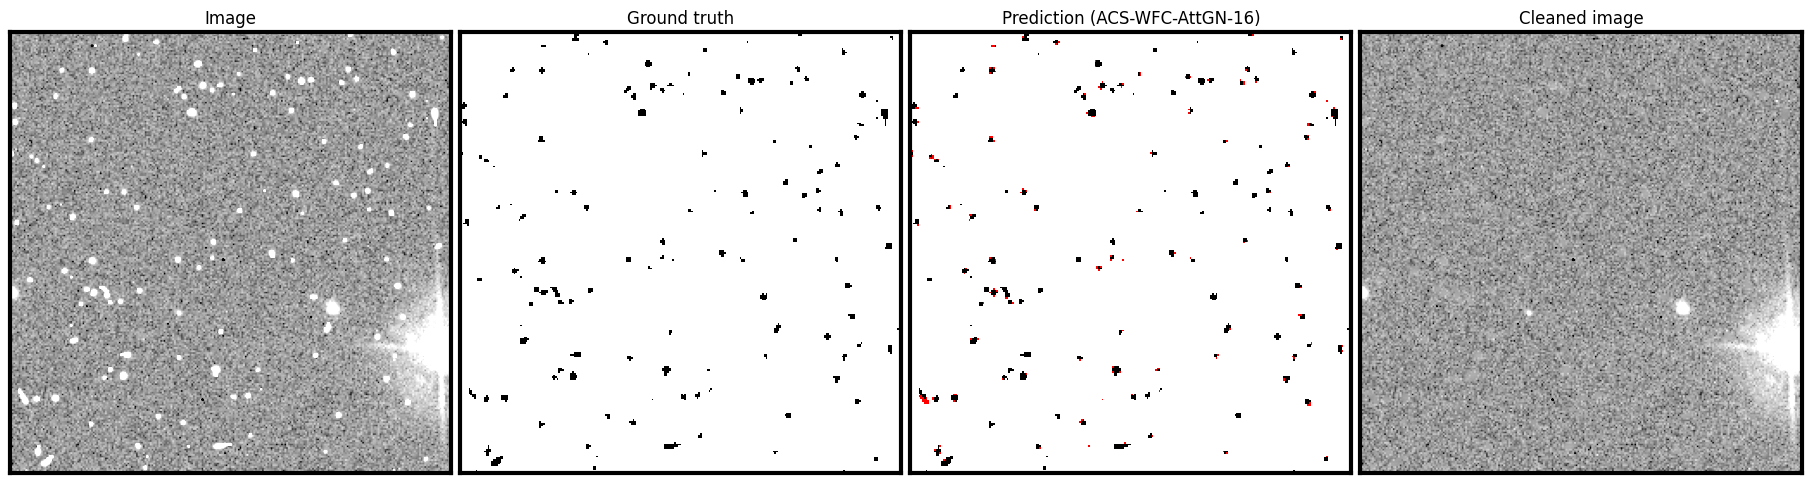

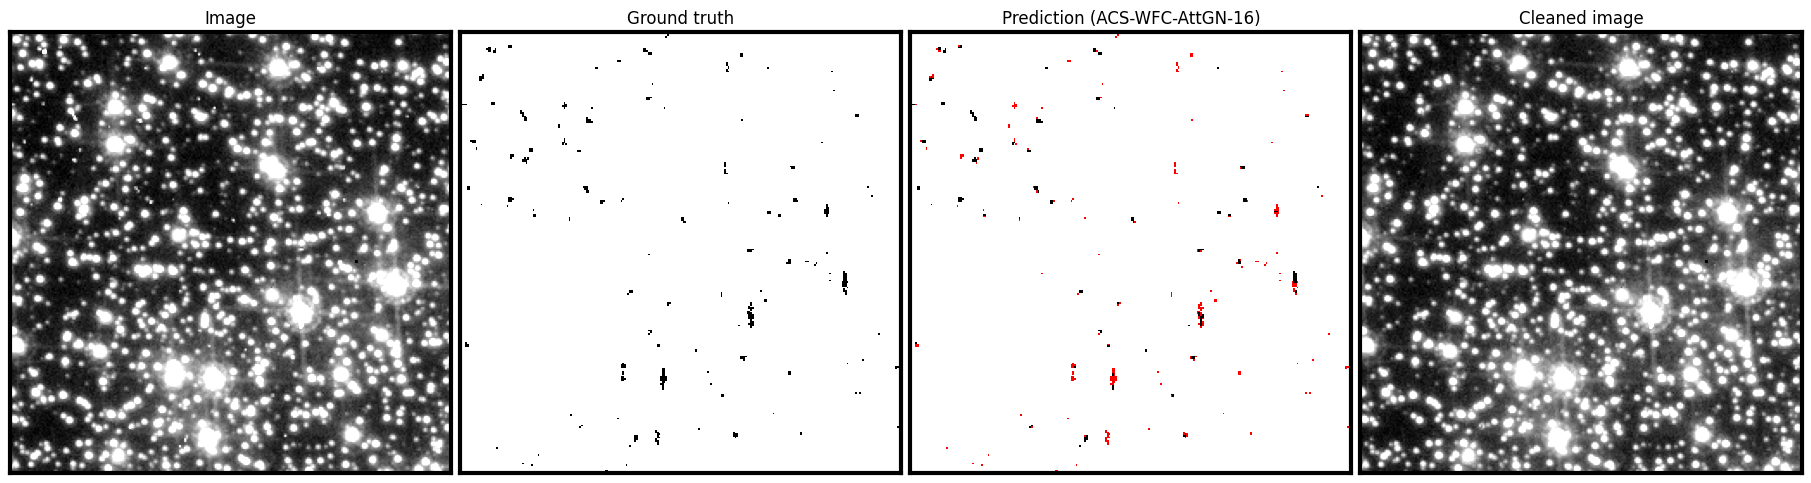

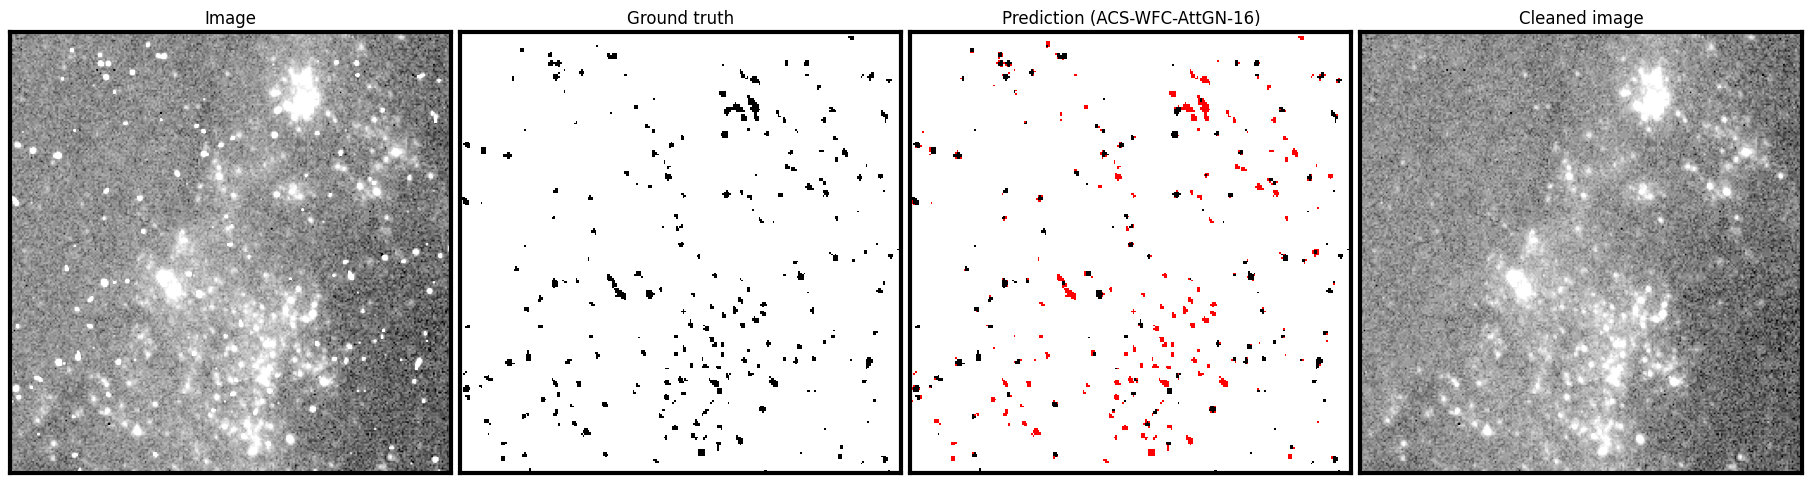

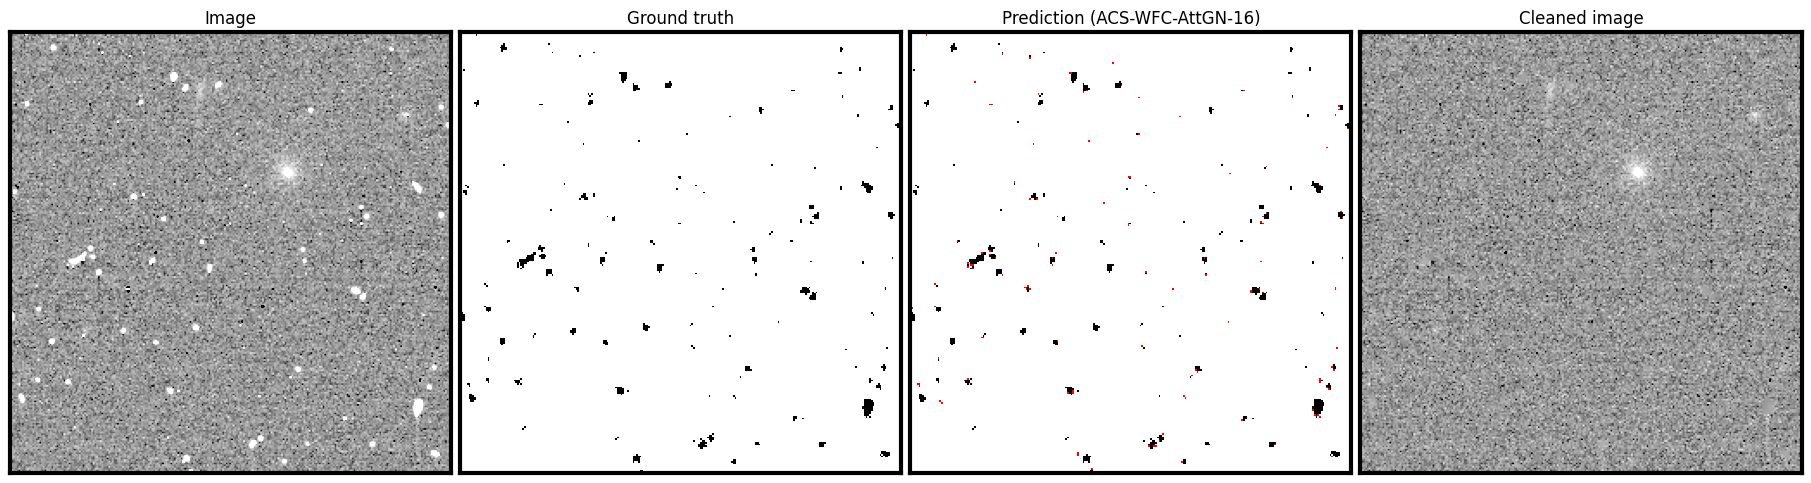

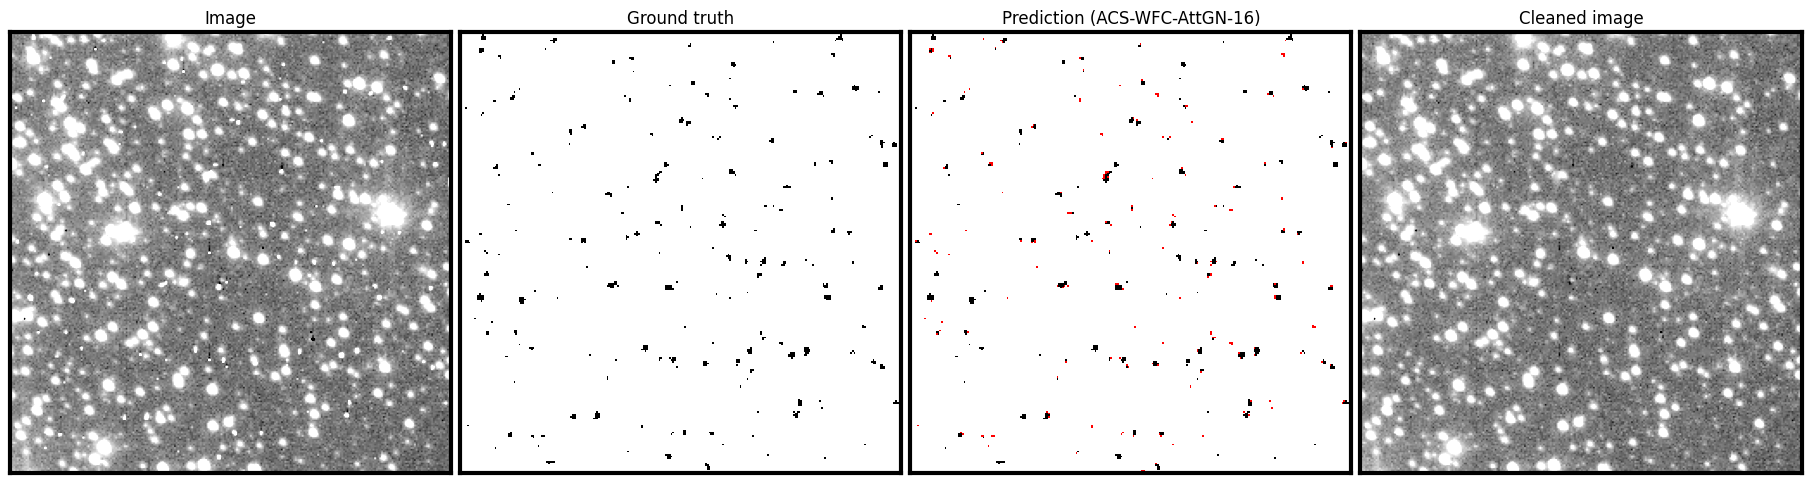

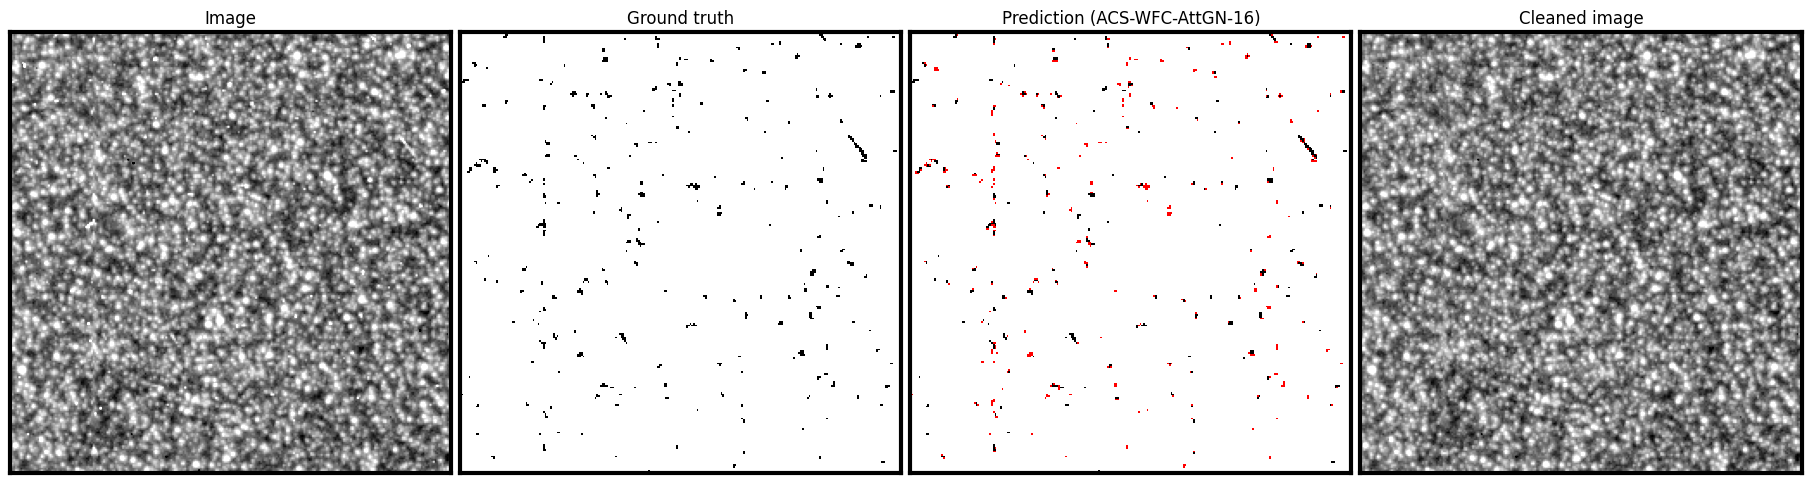

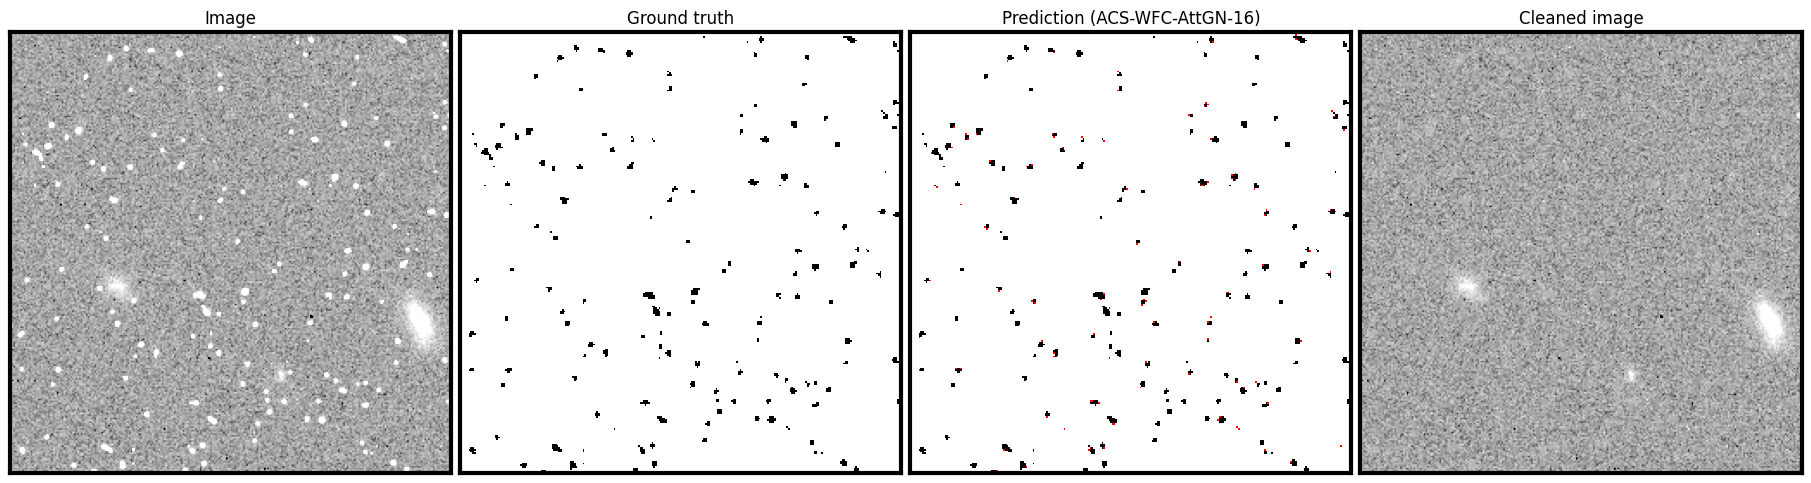

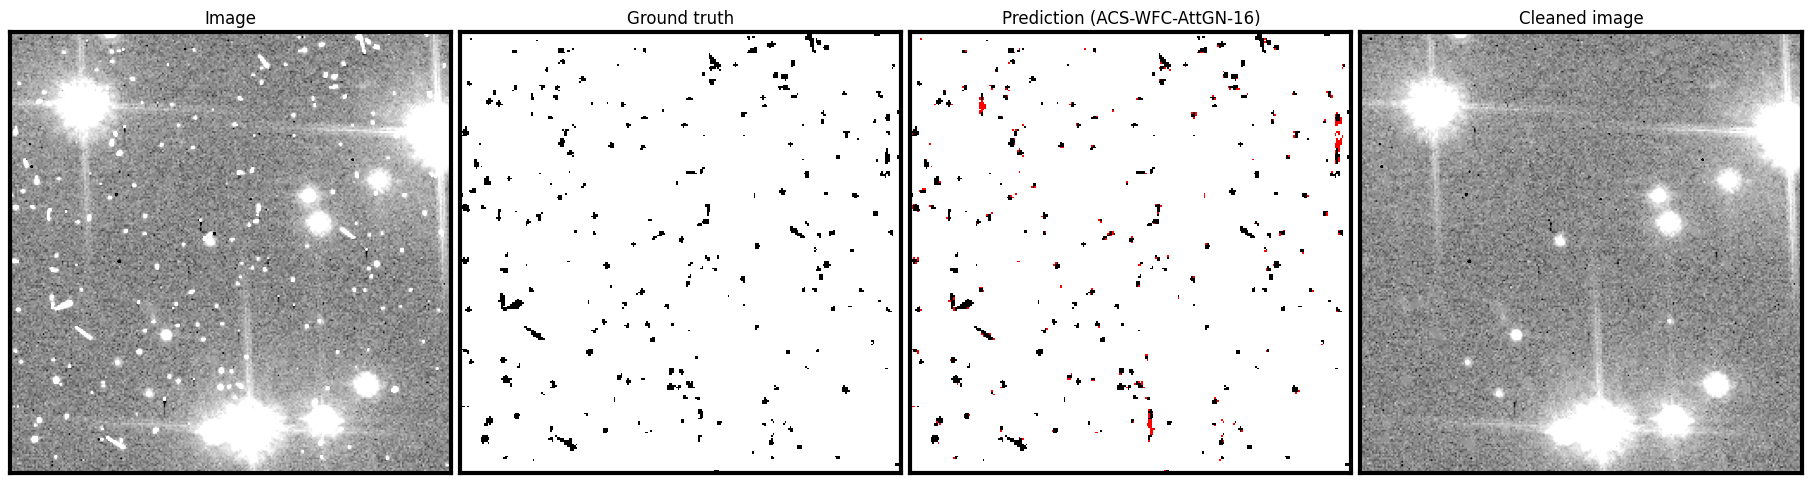

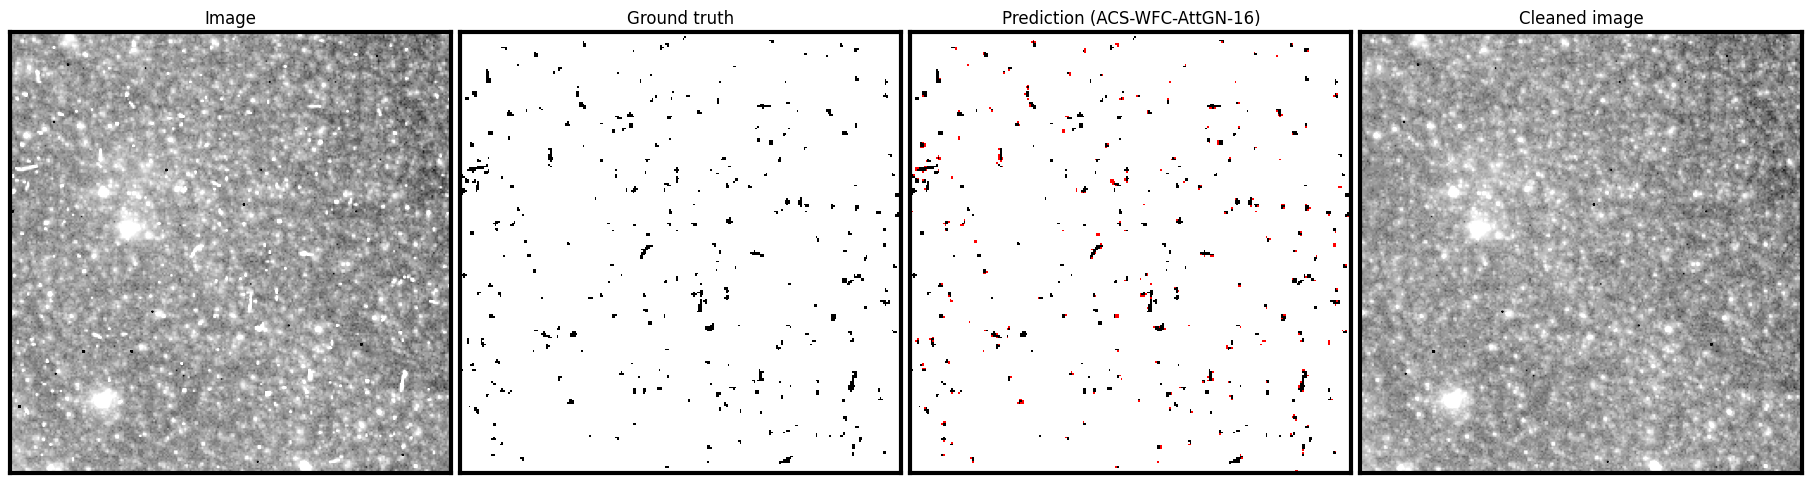

In [10]:
examples = [
    # ---------- F435W ----------
    ('f435w', '9694',  '6', '1_210.npy', 2.0,  'EX',  'F435W'),
    ('f435w', '10120', '3', '1_200.npy', 3.5,  'GC',  'F435W'),
    ('f435w', '10342', '3', '1_209.npy', 5.0,  'GAL', 'F435W'),

    # ---------- F606W ----------
    ('f606w', '12438', '1', '1_134.npy', 2.0,  'EX',  'F606W'),
    ('f606w', '11586', '5', '1_100.npy', 3.5,  'GC',  'F606W'),
    ('f606w', '10407', '3', '1_156.npy', 5.0,  'GAL', 'F606W'),

    # ---------- F814W ----------
    ('f814w', '10092', '1', '1_210.npy', 2.0,  'EX',  'F814W'),
    ('f814w', '12602', '1', '1_129.npy', 3.5,  'GC',  'F814W'),
    ('f814w', '13804', '6', '1_200.npy', 5.0,  'GAL', 'F814W'),
]

for flt, prop, visit, fname, objlim, field, filt_tag in examples:

    npy_path = os.path.join(
        BASE_DIR, 'data', 'npy_test',
        flt, prop, visit, fname
    )

    data = np.load(npy_path)

    pdt_mask, cleanArr = crnet.clean(data[0], threshold=0.5, inpaint=True, binary=True, 
                              fill_method="maskfill", fill_size=5,)


    plotCRDetection(
        data[0], data[1],
        pdt_mask, cleanArr,
        model_name=MODEL_NAME,
        save_path=os.path.join(
            OUT_DIR, f"{filt_tag}_{field}_{MODEL_NAME}.png"
        )
    )


#### Step 3: Test the Model

In [11]:
# Model Test

def model_test():
    
    test_dirs = np.load(os.path.join(BASE_DIR, "test_dirs.npy"), allow_pickle=True)

    field_type = {'10120_3': 'GC', '11340_11': 'GC', '9694_6': 'EX', '10342_3': 'GAL',   
                 '10407_3': 'GAL', '13364_95': 'GAL', '11586_5':'GC', '12438_1': 'EX', 
                 '10092_1': 'EX', '12602_1': 'GC', '12058_6': 'GAL', '13804_6': 'GAL'
                 }

    f814_test_field_dirs = {"GC": [], "EX": [], "GAL": []}
    f606_test_field_dirs = {"GC": [], "EX": [], "GAL": []}
    f435_test_field_dirs = {"GC": [], "EX": [], "GAL": []}

    for _dir in test_dirs:
        arr = _dir.split("/")
        _filter = arr[-4]
        key = f"{arr[-3]}_{arr[-2]}"
        f_type = field_type[key]

        if _filter == "f435w":
            f435_test_field_dirs[f_type].append(_dir)
        elif _filter == "f606w":
            f606_test_field_dirs[f_type].append(_dir)
        elif _filter == "f814w":
            f814_test_field_dirs[f_type].append(_dir)
    
    # F435W
    print("------------------------------------------------------------")
    print("Testing ACS/WFC model on F435W testset")
    print("------------------------------------------------------------")

    for f_type, dirs in f435_test_field_dirs.items():
        tpr_fpr, tpr_fpr_dilate = roc(crnet, dirs[::], dilate=True)

        tpr, fpr = tpr_fpr
        tpr_d, fpr_d = tpr_fpr_dilate

        np.save(
            os.path.join(OUT_DIR, f"F435W_{f_type}_{MODEL_NAME}.npy"),
            [[tpr, fpr], [tpr_d, fpr_d]],
        )

    # F606W
    print("------------------------------------------------------------")
    print("Testing ACS/WFC model on F606W testset")
    print("------------------------------------------------------------")

    for f_type, dirs in f606_test_field_dirs.items():
        tpr_fpr, tpr_fpr_dilate = roc(crnet, dirs[::], dilate=True)

        tpr, fpr = tpr_fpr
        tpr_d, fpr_d = tpr_fpr_dilate

        np.save(
            os.path.join(OUT_DIR, f"F606W_{f_type}_{MODEL_NAME}.npy"),
            [[tpr, fpr], [tpr_d, fpr_d]],
        )

    # F814W
    print("------------------------------------------------------------")
    print("Testing ACS/WFC model on F814W testset")
    print("------------------------------------------------------------")

    for f_type, dirs in f814_test_field_dirs.items():
        tpr_fpr, tpr_fpr_dilate = roc(crnet, dirs[::], dilate=True)

        tpr, fpr = tpr_fpr
        tpr_d, fpr_d = tpr_fpr_dilate

        np.save(
            os.path.join(OUT_DIR, f"F814W_{f_type}_{MODEL_NAME}.npy"),
            [[tpr, fpr], [tpr_d, fpr_d]],
        )

    return None

# run full test
model_test()


------------------------------------------------------------
Testing ACS/WFC model on F435W testset
------------------------------------------------------------


100%|██████████| 420/420 [05:53<00:00,  1.19it/s]


------------------------------------------------------------
Testing ACS/WFC model on F606W testset
------------------------------------------------------------


100%|██████████| 1050/1050 [14:43<00:00,  1.19it/s]


------------------------------------------------------------
Testing ACS/WFC model on F814W testset
------------------------------------------------------------


100%|██████████| 1050/1050 [14:38<00:00,  1.20it/s]


------------------------------------------------------------
Plotting F435W testing result
------------------------------------------------------------
------------------------------------------------------------
Plotting F606W testing result
------------------------------------------------------------
------------------------------------------------------------
Plotting F814W testing result
------------------------------------------------------------


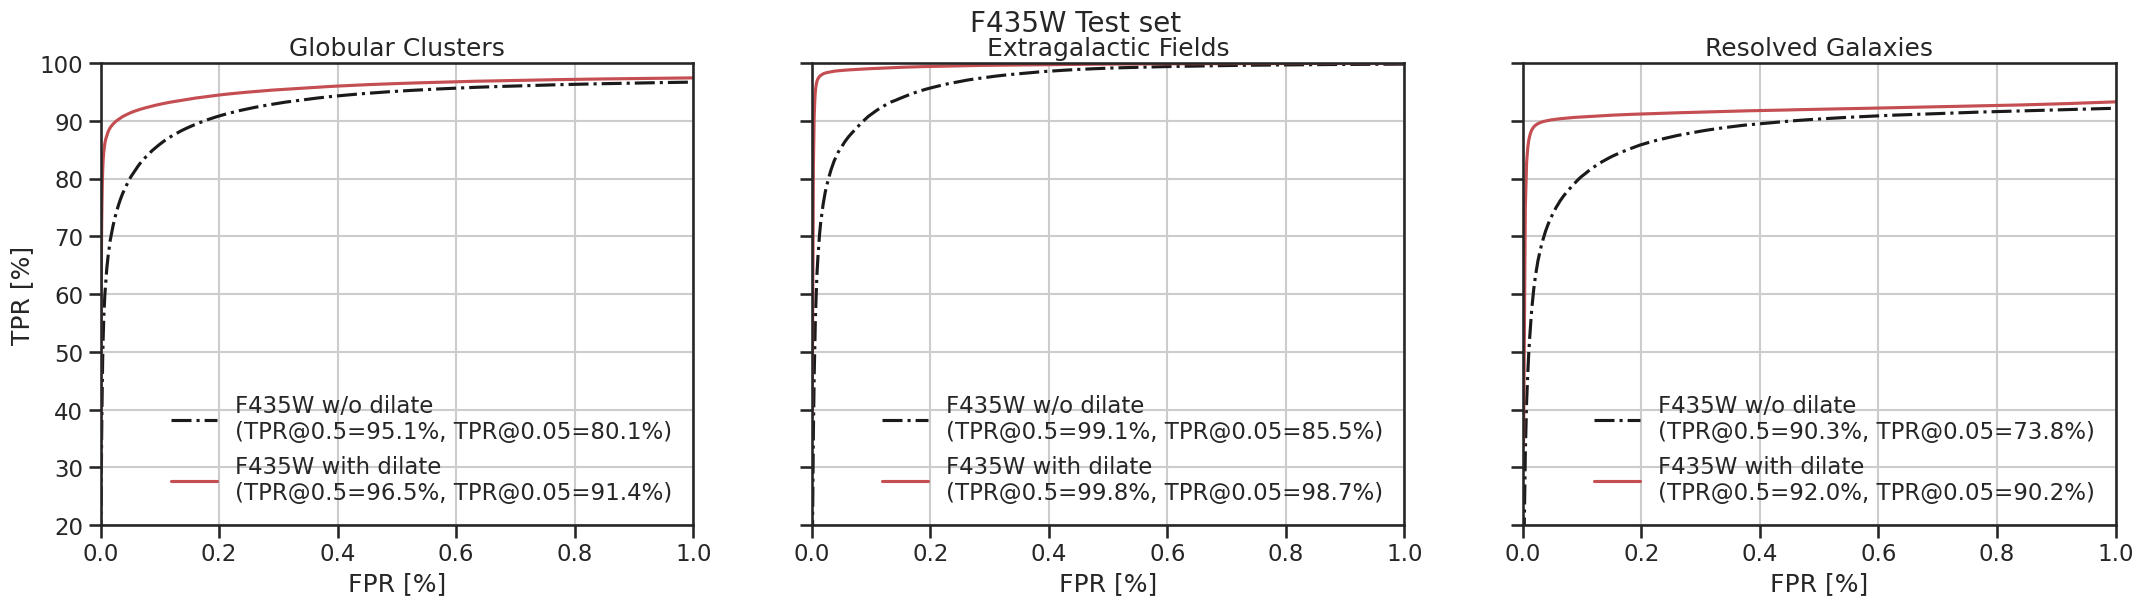

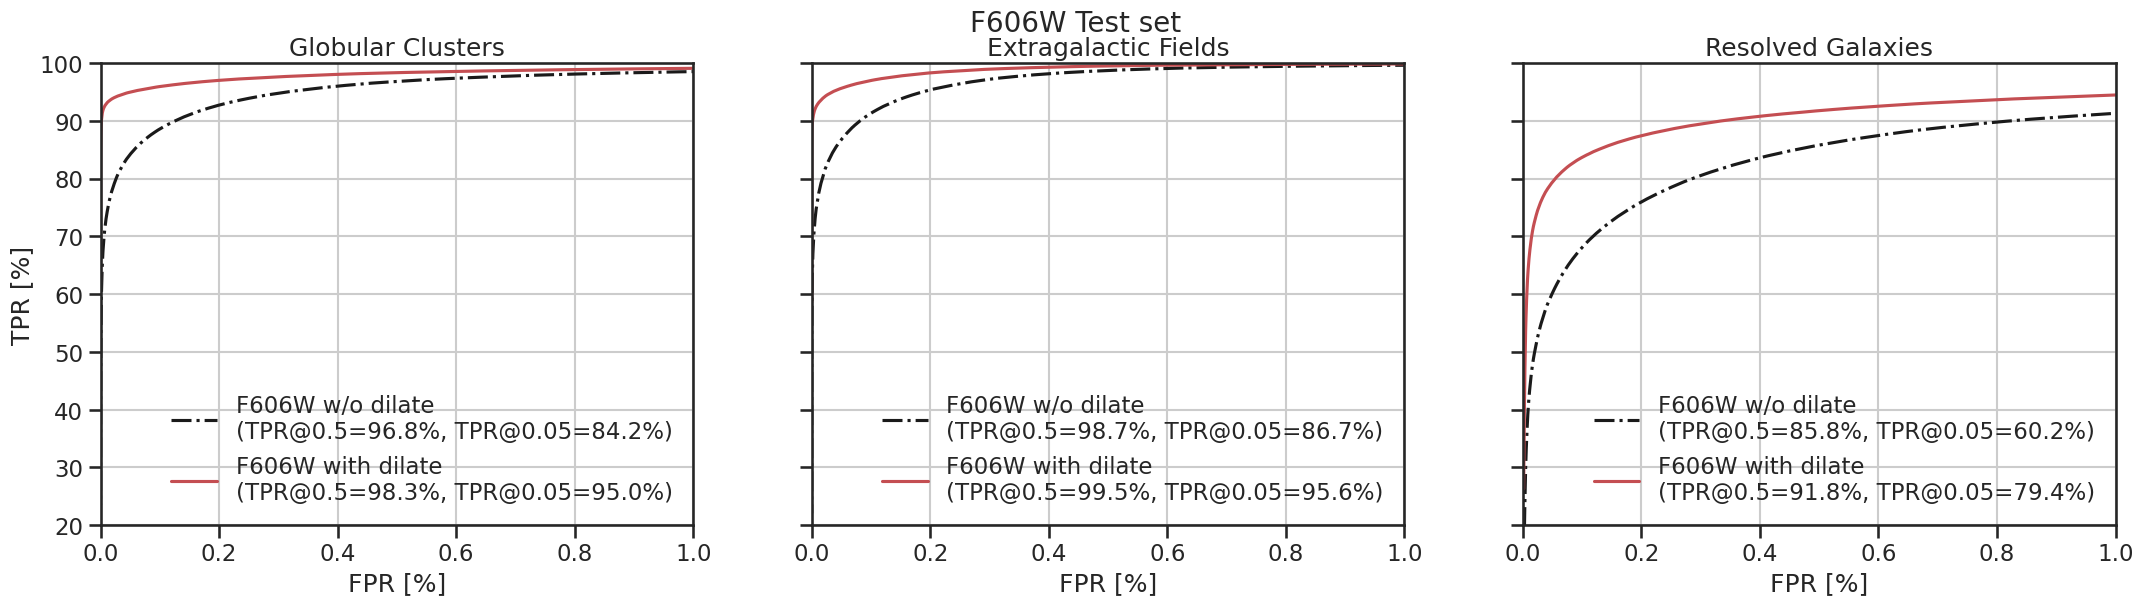

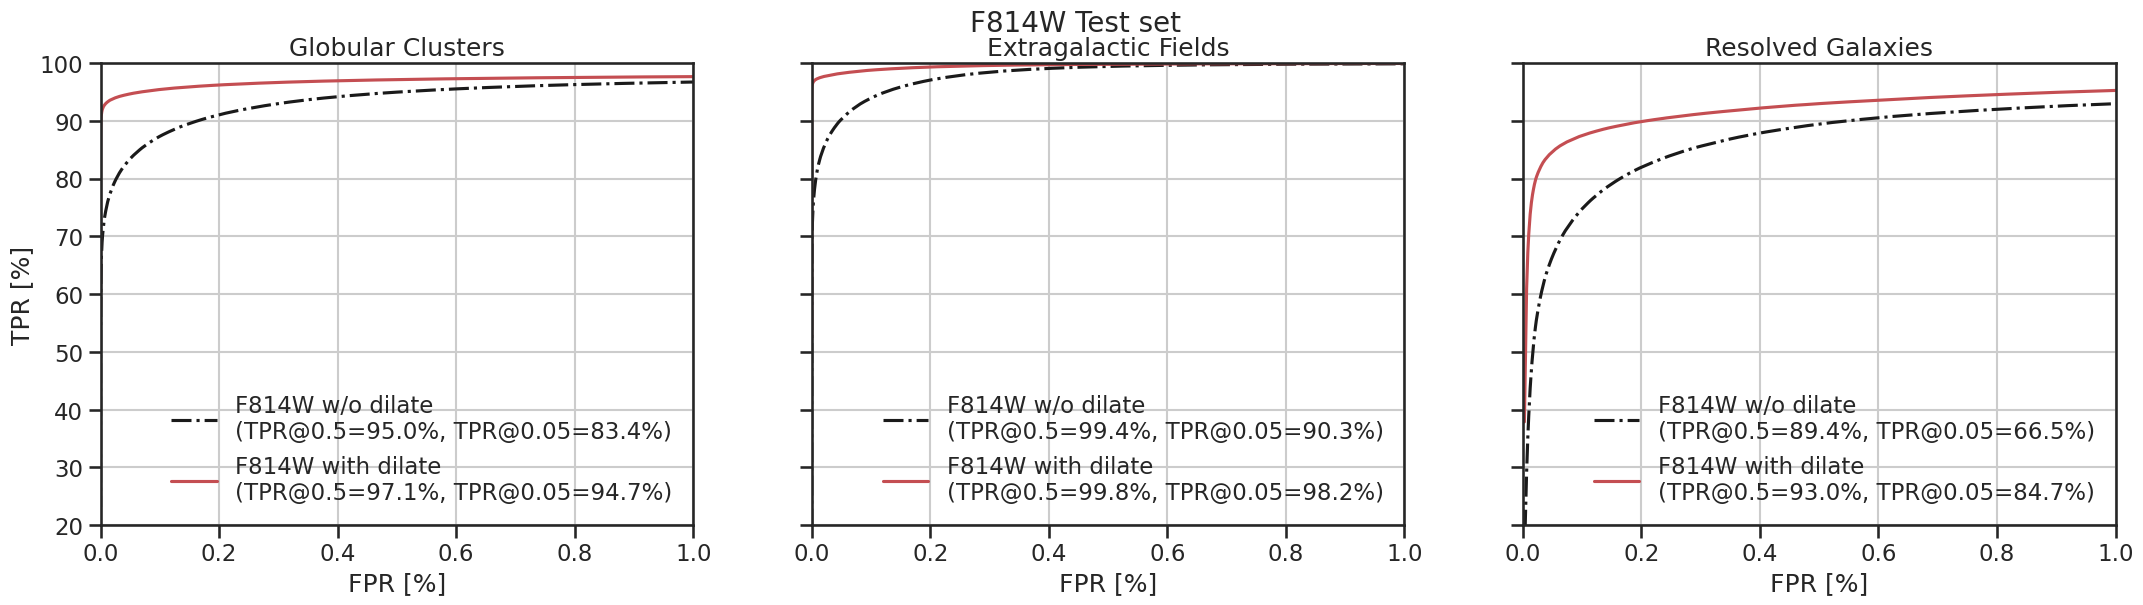

In [12]:
# Global variable for dilation control (kept as in your reference; not strictly needed here)
dilate = True  # Set to True for dilated, False for non-dilated

def plot_result():
    sns.set_theme(style="ticks", context='talk')
    
    print('------------------------------------------------------------')
    print('Plotting F435W testing result')
    print('------------------------------------------------------------')
    _plotter('F435W')

    print('------------------------------------------------------------')
    print('Plotting F606W testing result')
    print('------------------------------------------------------------')
    _plotter('F606W')

    print('------------------------------------------------------------')
    print('Plotting F814W testing result')
    print('------------------------------------------------------------')
    _plotter('F814W')

    return None

def _plotter(filter_name):
    fig, axs = plt.subplots(1, 3, figsize=(26, 6), sharey=True, sharex=True)
    fig.suptitle(f'{filter_name} Test set', y=0.97, fontsize=20)
    
    tf_global_gc, tf_global_d_gc   = np.load(os.path.join(OUT_DIR, f'{filter_name}_GC_{MODEL_NAME}.npy'),  allow_pickle=True)
    tf_global_ex, tf_global_d_ex   = np.load(os.path.join(OUT_DIR, f'{filter_name}_EX_{MODEL_NAME}.npy'),  allow_pickle=True)
    tf_global_gal, tf_global_d_gal = np.load(os.path.join(OUT_DIR, f'{filter_name}_GAL_{MODEL_NAME}.npy'), allow_pickle=True)
    
    tf_global   = [tf_global_gc,  tf_global_ex,  tf_global_gal]
    tf_global_d = [tf_global_d_gc, tf_global_d_ex, tf_global_d_gal]

    titles = ['Globular Clusters', 'Extragalactic Fields', 'Resolved Galaxies']

    for i in range(3):
        axs[i].set_title(titles[i])
        axs[i].set_xlabel('FPR [%]')
        axs[i].grid()
        axs[i].set_xlim(0, 1)
        axs[i].set_ylim(20, 100)

        # Data: w/o dilation and with dilation
        t_global, f_global = tf_global[i]
        t_global_d, _ = tf_global_d[i]
        f_global_d = f_global

        # Convert to numpy arrays and sort for proper interpolation
        f_global = np.array(f_global)
        t_global = np.array(t_global)
        sort_idx = np.argsort(f_global)
        sorted_f_global = f_global[sort_idx]
        sorted_t_global = t_global[sort_idx]

        f_global_d = np.array(f_global_d)
        t_global_d = np.array(t_global_d)
        sort_idx_d = np.argsort(f_global_d)
        sorted_f_global_d = f_global_d[sort_idx_d]
        sorted_t_global_d = t_global_d[sort_idx_d]

        # Compute TPR at FPR = 0.5
        tpr_no_dilate_05 = np.interp(0.5, sorted_f_global, sorted_t_global)
        tpr_dilate_05    = np.interp(0.5, sorted_f_global_d, sorted_t_global_d)

        # >>> NEW: Compute TPR at FPR = 0.05 <<<
        tpr_no_dilate_005 = np.interp(0.05, sorted_f_global, sorted_t_global)
        tpr_dilate_005    = np.interp(0.05, sorted_f_global_d, sorted_t_global_d)

        # Legend labels (extended, nothing removed)
        label_no_dilate = (
            f'{filter_name} w/o dilate\n'
            f'(TPR@0.5={tpr_no_dilate_05:.1f}%, '
            f'TPR@0.05={tpr_no_dilate_005:.1f}%)'
        )
        label_dilate = (
            f'{filter_name} with dilate\n'
            f'(TPR@0.5={tpr_dilate_05:.1f}%, '
            f'TPR@0.05={tpr_dilate_005:.1f}%)'
        )

        # Plot styles (unchanged)
        axs[i].plot(f_global, t_global, label=label_no_dilate, ls='-.', c='k')
        axs[i].plot(f_global_d, t_global_d, label=label_dilate, c='r', ls='-')

        axs[i].legend(frameon=False, loc='lower right')

    axs[0].set_ylabel('TPR [%]')

    fig.savefig(os.path.join(OUT_DIR, f'{filter_name}_ROC_{MODEL_NAME}.pdf'), format='pdf', bbox_inches='tight')
    return None

plot_result()


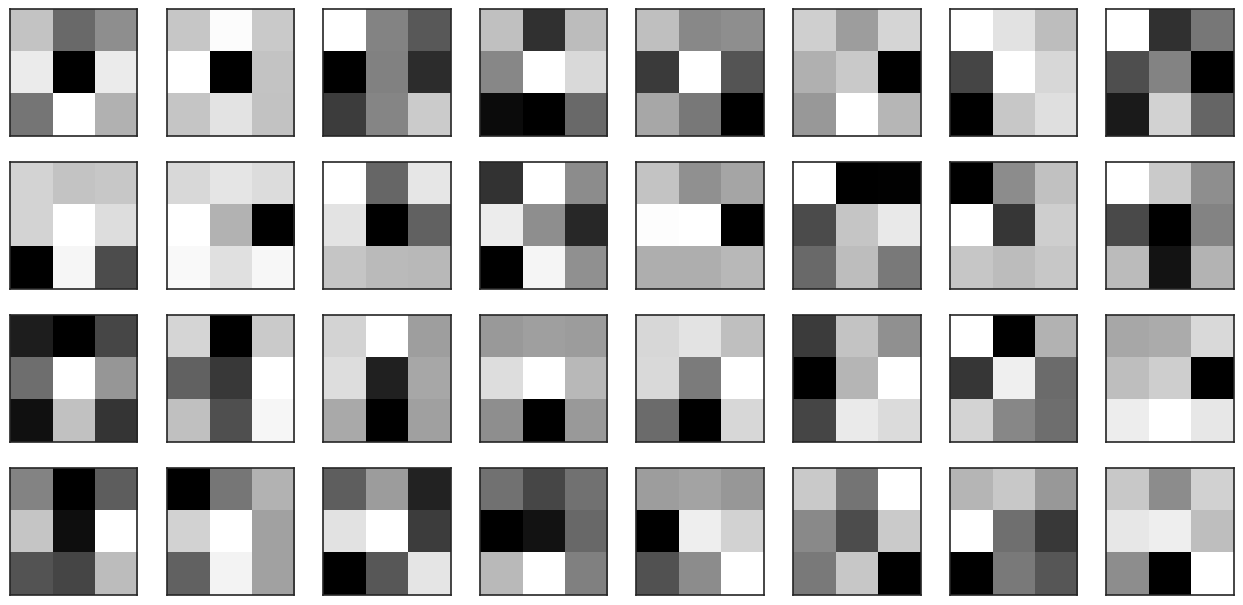

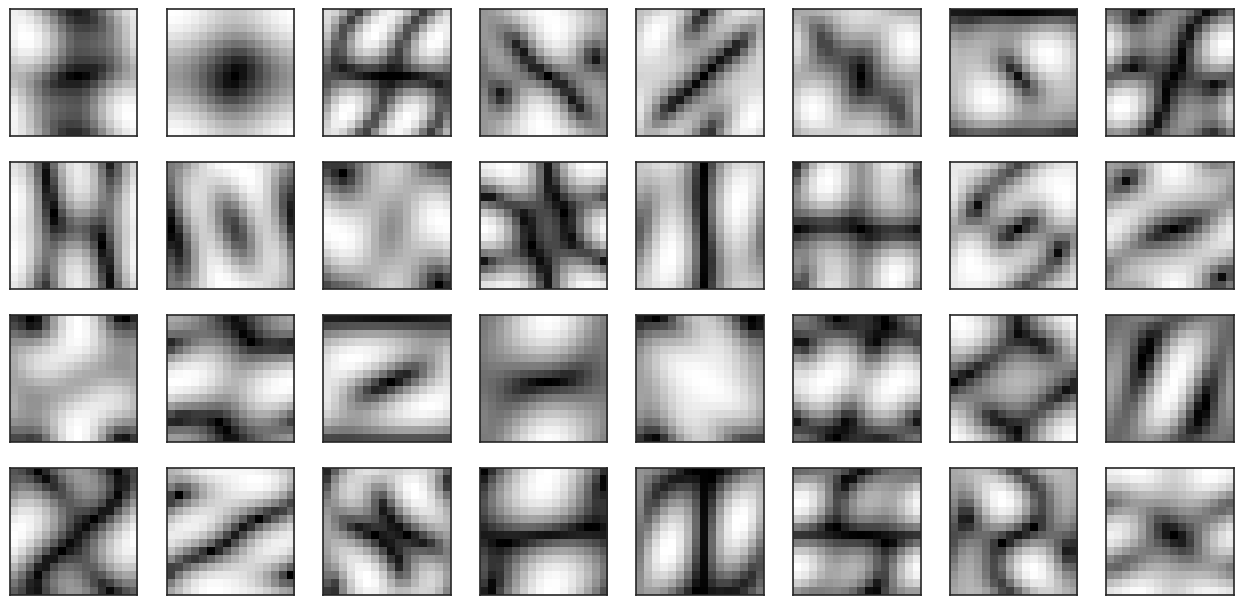

('ACS-WFC-AttGN-16/First_ConvFilters_ACS-WFC-AttGN-16.png',
 'ACS-WFC-AttGN-16/First_ConvFiltersdft16_ACS-WFC-AttGN-16.png')

In [13]:
plotFirstConvFilters(
    crnet,
    save_path_filters=os.path.join(OUT_DIR, f"First_ConvFilters_{MODEL_NAME}.png"),
    save_path_dft=os.path.join(OUT_DIR, f"First_ConvFiltersdft16_{MODEL_NAME}.png"),
)
